## Anna Kaniowska - Cellphones & Accessories dataset analysis

The goal of this project is to extract as much information form the data set that can be obtained here - http://snap.stanford.edu/data/amazon/Cell_Phones_&_Accessories.txt.gz (source: http://snap.stanford.edu/data/web-Amazon-links.html)

In [1]:
# All imports needed to perform the analysis
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.decomposition import PCA
from wordcloud import WordCloud

#### Loading the dataset

In [2]:
# A modified version of function available on the source page
def parse(filename):
    """
    Parses a gzipped text file and returns a list of dictionaries containing the parsed data.

    Parameters:
    filename (str): The path to the gzipped text file to be parsed.

    Returns:
    list: A list of dictionaries containing the parsed data.
    """
    f = gzip.open(filename, 'rb')
    entry = {}
    data = []
    for line in f:
        l = line.decode('utf-8').strip()
        colonPos = l.find(':')
        if colonPos == -1:
            data.append(entry)
            entry = {}
            continue
        eName = l[:colonPos]
        rest = l[colonPos+2:]
        entry[eName] = rest
    data.append(entry)
    return data

# Loading the dataset
data = parse('Cell_Phones_&_Accessories.txt.gz')
df = pd.DataFrame(data)


#### Getting to know the dataset

In [3]:
df.head(10)

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,1233360000,Don't buy!,"First of all, the company took my money and se..."
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,1191456000,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,1186704000,good,works real good....a little hard to set up...w...
3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A29Q0CLOF0U8BN,E. Owens,4/5,4.0,1146182400,No instructions included...,The price was right for this cable ($11.95+$4....
4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,1173657600,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...
5,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A2DP6EPPQAIL3C,David M. Cantrell,0/0,4.0,1171584000,works as expected,There's not much to say about a data cable -- ...
6,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A254KU5H615J3N,J. S. Gaviota,0/0,5.0,1142467200,Excellent product!,"I have a Sony Ericsson K700i, which doesn't se..."
7,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,ACVTUAQ4RUGK,"Parathalyn ""Parathalyn""",0/0,1.0,1133654400,Beware 3rd Party Cables & Sony Ericsson Tech S...,"Well, it technically does what it is supposed ..."
8,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A34D9XVHS261KT,D. Cram,1/2,3.0,1135814400,"Undecided on product, but Electro Island is A+...",I currently have this item for my S/E z500a ph...
9,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A3Q3B32YUDC3IK,"Jonathan C. Phillips ""Chris""",6/10,4.0,1126915200,Good cable to have,This is a good cable to have. You don't need t...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78931 entries, 0 to 78930
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   product/productId   78930 non-null  object
 1   product/title       78930 non-null  object
 2   product/price       78930 non-null  object
 3   review/userId       78930 non-null  object
 4   review/profileName  78930 non-null  object
 5   review/helpfulness  78930 non-null  object
 6   review/score        78930 non-null  object
 7   review/time         78930 non-null  object
 8   review/summary      78930 non-null  object
 9   review/text         78930 non-null  object
dtypes: object(10)
memory usage: 6.0+ MB


In [5]:
df.describe()

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
count,78930,78930,78930,78930,78930,78930,78930,78930,78930,78930
unique,7438,7150,944,68041,63370,1305,5,4431,60321,77390
top,B0009B0IX4,Plantronics Voyager 510 Bluetooth Headset [Ret...,unknown,unknown,unknown,0/0,5.0,1168300800,Great Product,I had been very happy with my Motorola phone u...
freq,3443,3443,43287,2276,2276,34920,30253,519,211,20


In [6]:
print(f"The shape of the dataset is: {df.shape}")

The shape of the dataset is: (78931, 10)


Taking a first look at the data, it is visible that it shows the reviews that customers gave to the products. The products are mainly cellphones and their accesories. The dataset is big - almost 79 000 rows is a significant amount of data. 10 columns provide information about the rated product, the customer and their opinion on the product. When it comes to technical details - it is necessary to change 'unknown' values to NaN in order to prepare data to further analysis. Checking the dataset for duplicated rows and dropping existing ones is also necessary because this is something that cannot be seen at first glance. Another conclusion is that the types of the columns are not necessarily correct (e.g. product/price should be stored as float), it is also needed to be corrected.

## Feature Engineering & Exploratory Data Analysis

#### Checking for duplicated rows

In [7]:
print(f"There is {df.duplicated().sum()} duplicated rows in the dataset")

There is 36 duplicated rows in the dataset


In [8]:
df.drop_duplicates(inplace=True)

#### Handling missing values

In [9]:
df.replace("unknown", np.nan, inplace=True)

# Analyzing the missing values occurences
print("Missing values occurences:")
print(df.isna().sum())

# Checking anonymous reviews (those where userId and profileName is missing)
anon_reviews_perc = df['review/userId'].isna().sum()/df.shape[0] * 100
print(f"{anon_reviews_perc:.2f}% of the reviews are anonymously submitted.")


Missing values occurences:
product/productId         1
product/title             1
product/price         43266
review/userId          2275
review/profileName     2275
review/helpfulness        1
review/score              1
review/time               1
review/summary            1
review/text               1
dtype: int64
2.88% of the reviews are anonymously submitted.


The first conclusion is one row that can be safely deleted in each column (it is very likely that it is the same row for each of the columns). \
The second conclusion refers to anonymous reviews. When missing values are less than 5% of given feature, they can be safely deleted without having impact on further analysis. For now the data will be divided into to sets - first with anonymous reviews and second with named reviews. It may be useful to further analysis.

In [10]:
# Extracting columns with 1 missing value
cols = ['product/productId', 'product/title', 'review/helpfulness', 'review/score', 'review/time', \
        'review/summary', 'review/text']
df = df.dropna(subset=cols)
print(f"Shape of the dataset after dropping NaNs: {df.shape}")

Shape of the dataset after dropping NaNs: (78894, 10)


As expected, only one row of the data was deleted.

Before dividing dataset into two separate dataset it would be useful to correct the columns' types.

#### Correcting columns types

In [11]:
df['product/price'] = pd.to_numeric(df['product/price'], errors='coerce')
df['review/score'] = pd.to_numeric(df['review/score'], errors='coerce')
df['review/time'] = pd.to_datetime(df['review/time'].astype(float), unit='s')

def handle_helpfulness(x):
    """
    Converts the string representation of helpfulness scores to a float value between 0 and 1.

    Parameters:
        helpfulness (str): The string representation of helpfulness scores, in the format "x/y",
        where "x" is the number of users who found the review helpful and "y" is the total number of votes.

    Returns:
        float: The float value of the helpfulness score, calculated as "x / y". Returns 0 if "y" is 0.
    """
    try:
        nom, denom = x.split("/")
        return int(nom) / int(denom)
    except (ValueError, ZeroDivisionError):
        return 0

df['review/helpfulness'] = df['review/helpfulness'].apply(handle_helpfulness)

The price and score columns are stroing numeric values, the review has time in seconds. When it comes to helpfulness it was transformed to the float value that represents it.

Coming back to the missing values before the set division, the last thing about them is the price. As it is a significant amount of data in the dataset it would not make sense to drop it. Taking into consideration that assigning a price of a small accessory to a brand new cellphone would distort the dataset, the missing values in this column will not be replaced with mean, median or mode. The products are stored in more or less an order (similiar products next to one another) so an optimal way to impute the missing values would be kNN method.

In [12]:
features_with_missing_values = df[['product/price']]
imputer = KNNImputer(n_neighbors=5)
imputed_features = imputer.fit_transform(features_with_missing_values)
df['product/price'] = imputed_features

#### Division of a dataset

In [13]:
# Dividing the dataset into anonymous and named
df_anon = df[(df['review/userId'].isna()) & (df['review/profileName'].isna())]
df_named = df[~(df['review/userId'].isna()) & ~(df['review/profileName'].isna())]

# Deleting unnecessary columns from the anonymous reviews
df_anon = df_anon.drop(columns=['review/userId', 'review/profileName'])

# Resetting index
df_named.reset_index(inplace=True, drop=True)
df_anon.reset_index(inplace=True, drop=True)

# Checking if everything went as expected
print(f"Missing values occurences in anonymous reviews dataset:\n{df_anon.isna().sum()}")
print(f"Missing values occurences in named reviews dataset:\n{df_named.isna().sum()}")

Missing values occurences in anonymous reviews dataset:
product/productId     0
product/title         0
product/price         0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64
Missing values occurences in named reviews dataset:
product/productId     0
product/title         0
product/price         0
review/userId         0
review/profileName    0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64


The analysis will focus on the named reviews but the anonymous ones will always be an available point of reference. This decision is supported by the fact that named reviews can be treated as more reliable.

#### Data Visualizations

In [14]:
# Taking a look on the prepared data
df_named.head()

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,31.842842,A1RXYH9ROBAKEZ,A. Igoe,0.0,1.0,2009-01-31,Don't buy!,"First of all, the company took my money and se..."
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,31.842842,A7L6E1KSJTAJ6,Steven Martz,0.0,5.0,2007-10-04,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,31.842842,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0.0,4.0,2007-08-10,good,works real good....a little hard to set up...w...
3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",31.842842,A29Q0CLOF0U8BN,E. Owens,0.8,4.0,2006-04-28,No instructions included...,The price was right for this cable ($11.95+$4....
4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",31.842842,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0.0,1.0,2007-03-12,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...


In [15]:
df_anon.head()

,product/productId,product/title,product/price,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000F1UQJY,Motorola HT820 Stereo Bluetooth Headset with m...,31.842842,0.5,3.0,2009-01-17,IT WONT PAIR WITH MY IPOD IN MY IPHONE,IT PAIRED WTH MY IPHONE FINE AND IT WORKS REAL...
1,B00004WINO,Audiovox Leather Carrying Case for Audiovox Ph...,31.842842,1.0,1.0,2001-01-20,Case doesn't fit phone properly,The case I had didn't fit properly - the windo...
2,B00004WINO,Audiovox Leather Carrying Case for Audiovox Ph...,31.842842,0.0,4.0,2002-08-19,"Case pretty classy, Clip not so great","Well constructed case, of good quality leather..."
3,B00004WINO,Audiovox Leather Carrying Case for Audiovox Ph...,31.842842,0.0,2.0,2001-08-27,Can you hear me now...Can you hear me now?,The averall construction is good but the place...
4,B00004WINO,Audiovox Leather Carrying Case for Audiovox Ph...,31.842842,0.0,4.0,2001-02-12,Good Fit &amp; Function,"The cover fits reasonably well, with only slig..."


In [16]:
# Extracting the columns with numercial and categorical variables
numerical = ['product/price', 'review/helpfulness', 'review/score', 'review/time']
categorical = ['product/productId', 'product/title', 'review/userId', 'review/profileName']

Summary and text would be difficult to visualize so those columns are not taken into consideration in this section.

#### a. Named Reviews

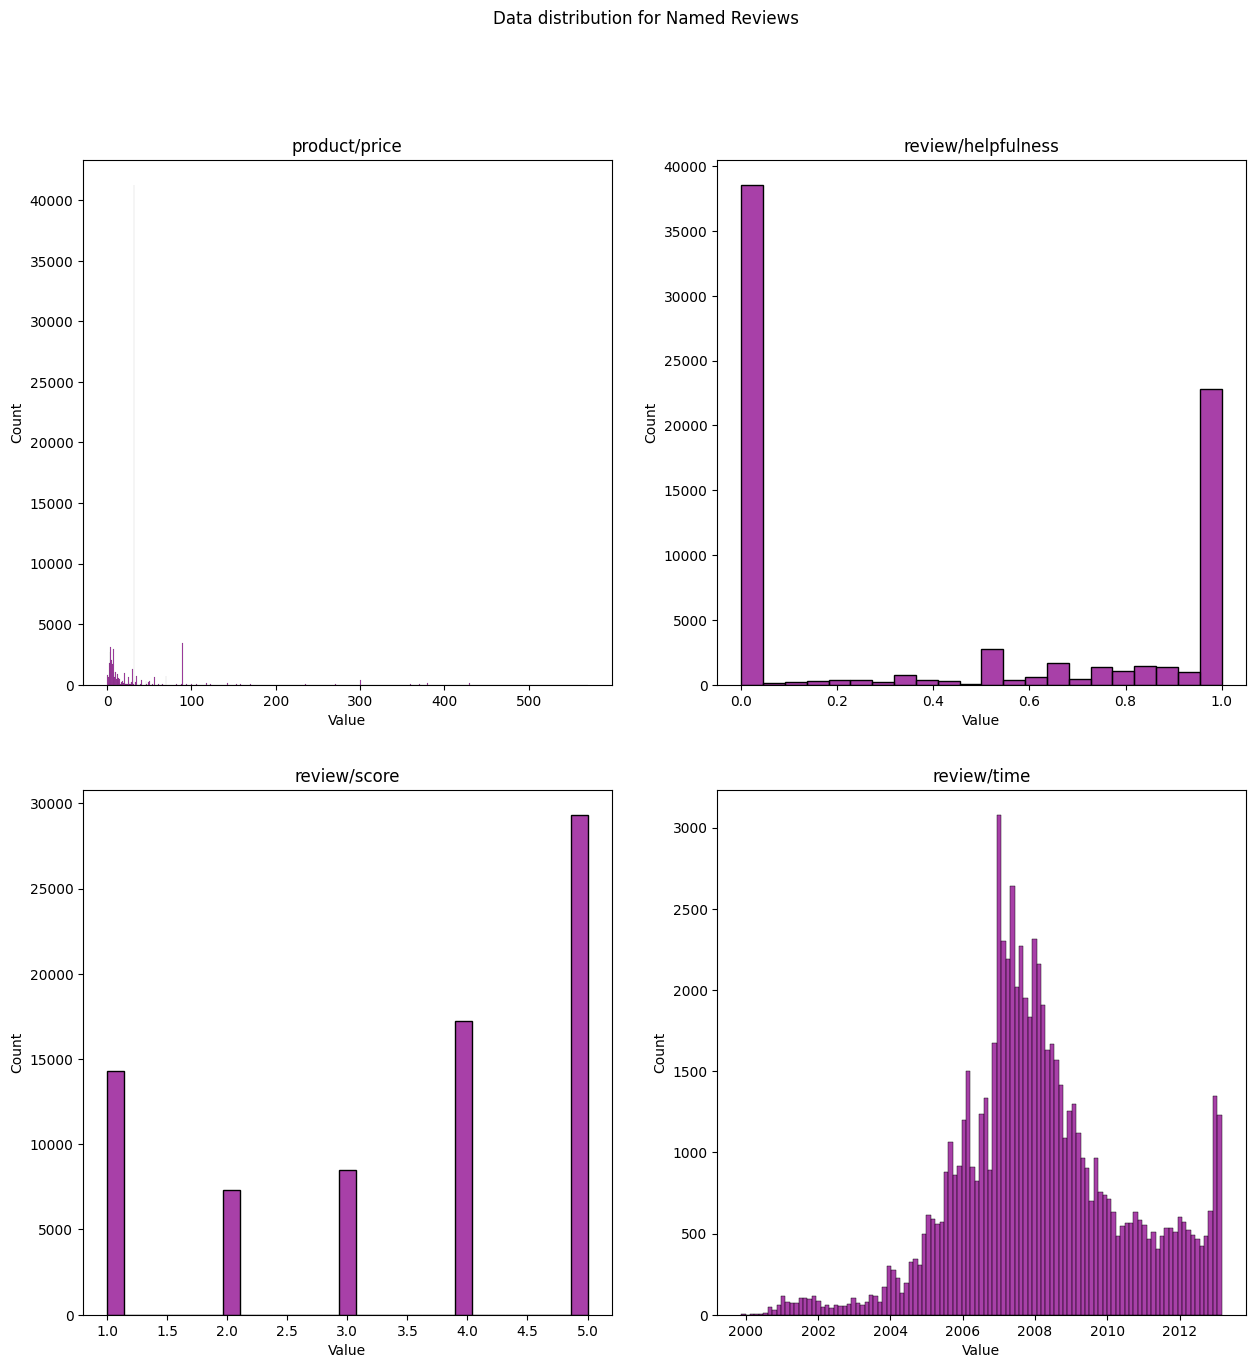

In [17]:
# Numerical variables
fig, axs = plt.subplots(2, 2, figsize=[15, 15])
fig.suptitle("Data distribution for Named Reviews")

max_counts = [df_named[col].value_counts().max() for col in numerical]
for i, col in enumerate(df_named[numerical]):
    sns.histplot(data=df_named, x=col, ax=axs[i//2, i%2], color='darkmagenta')
    axs[i//2, i%2].set(title=col, xlabel='Value')
plt.show()

It is visible that most of the reviews are rather extremely helpful or extremely unhelpful, something in between is not seen very often. A similiar situation can be observed in the Score histogram but not to such extent (4.0 note is observed more often than 1.0). Majority of reviews has a score 5.0 which is a sign of good quality of the products. \
What is interesting is that most of the reviews were registered in 2007-2008 which is the time of Global Financial Crisis. It suggests that during this time people were carefully watching their expenses and looking and the quality of products more than usual. This could lead to the highest amount of the reviews on the plot. There is another theory why this peak took place. In 2007 Amazon experienced servers outages that caused about 2 hours of downtime on the platform. It was a famous case, so when people talked about, they might have decided to use their services and write some reviews. The topics are not directly related but they both refer to Amazon websites so there might be a correlation. \
The plot which refers to the price is not very transparent, so in order to better understand the data there was a boxplot created.

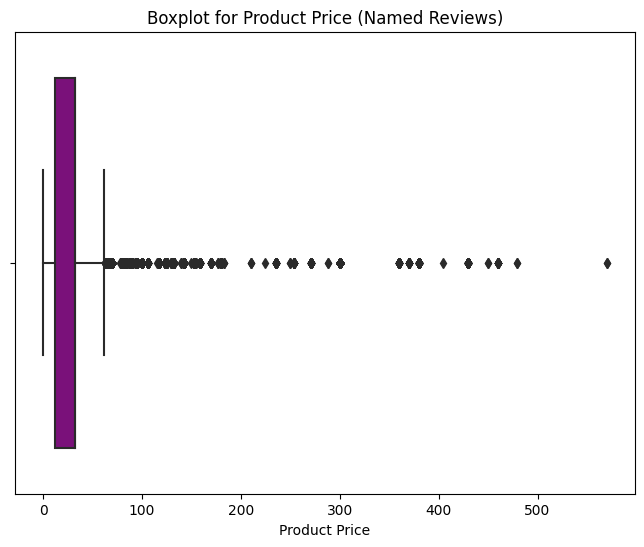

In [18]:
fig, ax = plt.subplots(figsize=[8,6])
sns.boxplot(x=df_named['product/price'], ax=ax, color='darkmagenta')
ax.set(xlabel='Product Price', title="Boxplot for Product Price (Named Reviews)")
plt.show()

It is important to remember that more than a half of the price values were imputed by kNN algorithm so the results might not be 100% reliable. That is also the reason why outliers are not removed. Majority of the product is in the cheaper section, while more expensive products are bought less often - they are treated as outliers in this dataset. Half of the dataset (between first and third quartile) is represented by (15,35) range (approximately).

#### b. Anonymous Reviews

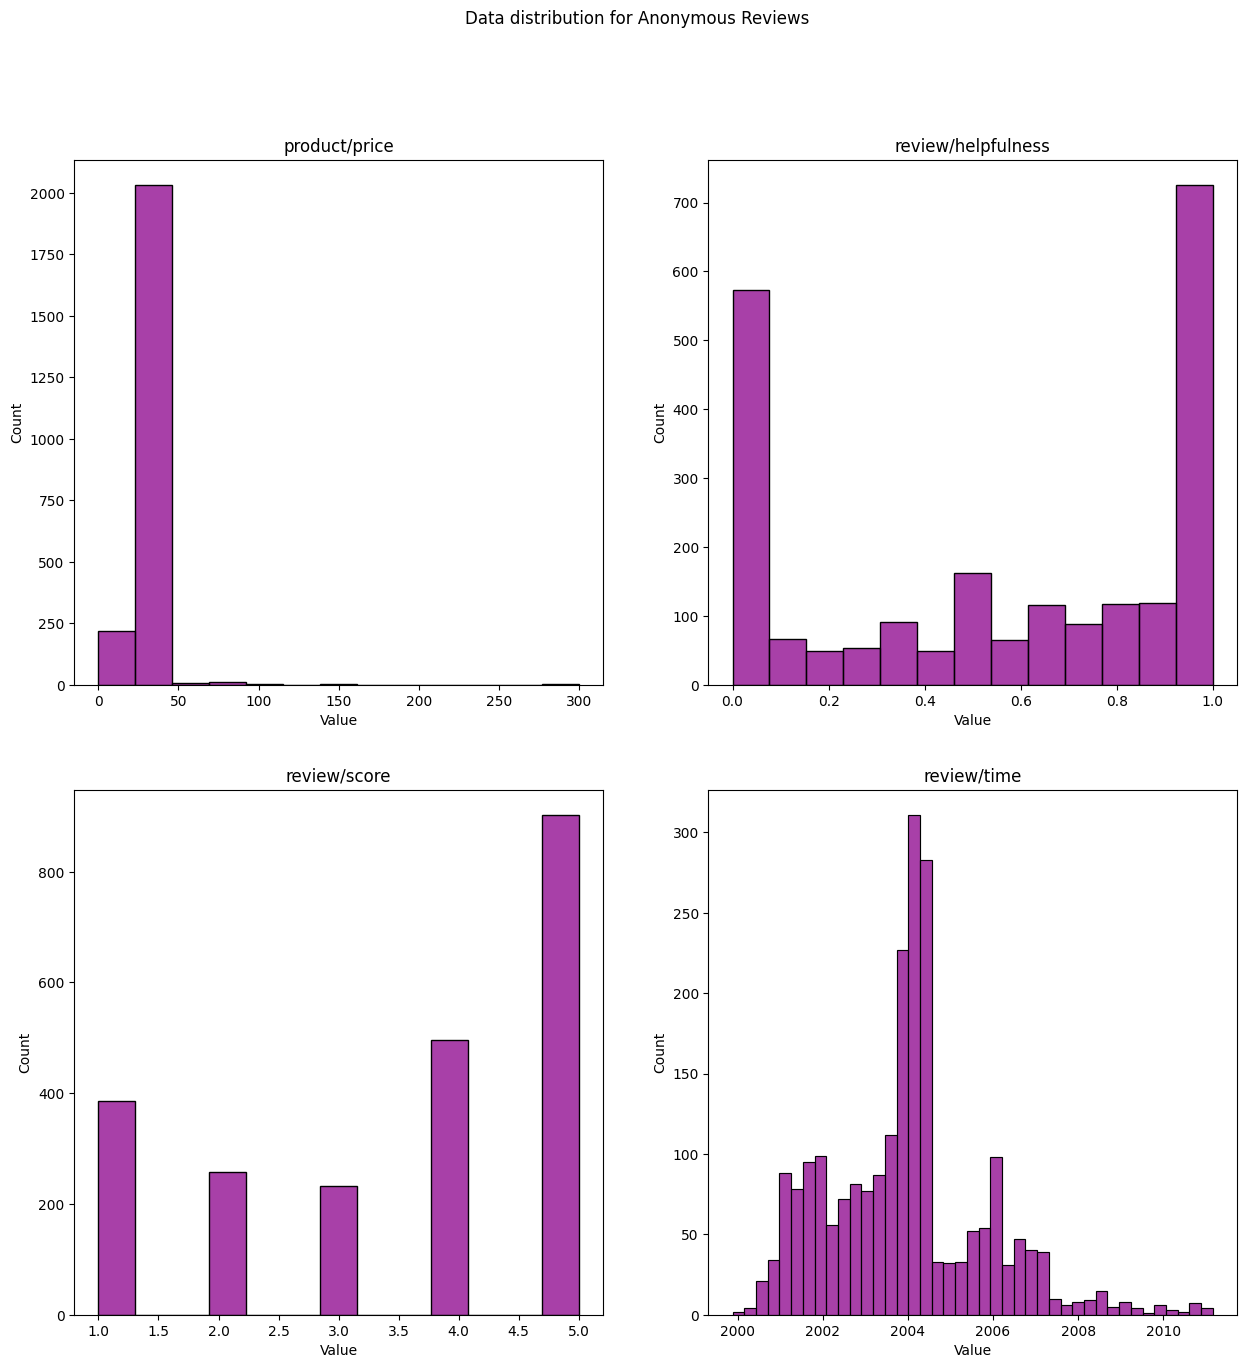

In [19]:
# Numerical variables
fig, axs = plt.subplots(2, 2, figsize=[15, 15])
fig.suptitle("Data distribution for Anonymous Reviews")

max_counts = [df_anon[col].value_counts().max() for col in numerical]
for i, col in enumerate(df_anon[numerical]):
    sns.histplot(data=df_anon, x=col, ax=axs[i//2, i%2], color='darkmagenta')
    axs[i//2, i%2].set(title=col, xlabel='Value')
plt.show()

The results are similar to those from Names Reviews dataset. The biggest difference is visible on the last plot - anonymous reviews were the most popular in 2004. It might prove that people in this time were not trusting the internet as much as they did in 2007-2008 and did not want to provide the personal data to any websites. It is also interesting to see that starting from 2008 the anonymous reviews are rarely observed.

## Machine Learning analysis

In this section there will appear several machine learning techiniques used to get as much information form the data as possible.

#### Natural Language Processing - data preparation

In [20]:
# Prepare necessary tools
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    """
    Preprocesses a given text by tokenizing it into words, converting all words to lowercase, 
    removing any non-alphabetic characters and stop words, and stemming the remaining words. 
    The processed words are then joined into a single string and returned.

    Args:
    text (str): A string of text to be preprocessed.

    Returns:
    str: The preprocessed text, consisting of stemmed words in lower case, with non-alphabetic characters and stop words removed and all words joined into a single string.
    """
    words = nltk.word_tokenize(text.lower())
    words = [w for w in words if w.isalpha() and w not in stop_words]
    words = [stemmer.stem(w) for w in words]
    return ' '.join(words)

df_named['text'] = df_named['review/summary'].apply(preprocess_text)
df_anon['text'] = df_anon['review/summary'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24224\2000986535.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_named['text'] = df_named['review/summary'].apply(preprocess_text)


At the beginning of Natural Language Processing it is necessary to prepare the data - handle to stop words, stemming or non-alphabetic characters. The choice between Summary and Text column was not easy, but both of the columns contain natural language, so Summary was picked.

#### Text analysis

In [21]:
# Creating a bag of words from the preprocessed text
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df_named['text'])

# Extracting the frequency of each word
word_freq = dict(zip(vectorizer.get_feature_names_out(), bag_of_words.sum(axis=0).tolist()[0]))
top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]

# Displaying top 10
print("Most common words:")
for word, freq in top_words:
    print(word, freq)

Most common words:
great 11176
phone 9284
good 7570
work 6672
headset 3869
product 3769
batteri 3026
bluetooth 2777
case 2323
best 2283


After this simple analysis it is visible that the most frequently used words are adjectives and adverbs like great, good, best. However, the words describing products like phone, case, headset or product itself are equally important. This confirms that the reviews are focused on rating the products and are not randomly written sentences. However, there are some typos like 'batteri' in them. It might suggest that not all of the customers are english native speakers which is very possible.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24224\2832455876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_named['polarity'] = df_named['review/text'].apply(lambda x: TextBlob(x).sentiment.polarity)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24224\2832455876.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_named['vader_scores'] = df_named['review/text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


(0, '0.120*"work" + 0.032*"charger" + 0.030*"well" + 0.024*"use" + 0.022*"need" + 0.019*"awesom" + 0.017*"cabl" + 0.013*"ear" + 0.013*"fine" + 0.012*"terribl"')
(1, '0.089*"headset" + 0.043*"bluetooth" + 0.038*"qualiti" + 0.034*"perfect" + 0.034*"good" + 0.031*"sound" + 0.031*"poor" + 0.026*"better" + 0.024*"get" + 0.023*"like"')
(2, '0.101*"good" + 0.088*"phone" + 0.036*"love" + 0.032*"excel" + 0.024*"money" + 0.021*"worth" + 0.019*"ok" + 0.019*"servic" + 0.015*"one" + 0.015*"cheap"')
(3, '0.224*"great" + 0.072*"product" + 0.051*"price" + 0.046*"good" + 0.034*"bad" + 0.033*"work" + 0.030*"nice" + 0.030*"case" + 0.017*"littl" + 0.016*"excel"')
(4, '0.176*"phone" + 0.054*"batteri" + 0.045*"best" + 0.035*"motorola" + 0.028*"cell" + 0.025*"buy" + 0.020*"ever" + 0.019*"case" + 0.018*"fit" + 0.017*"razr"')


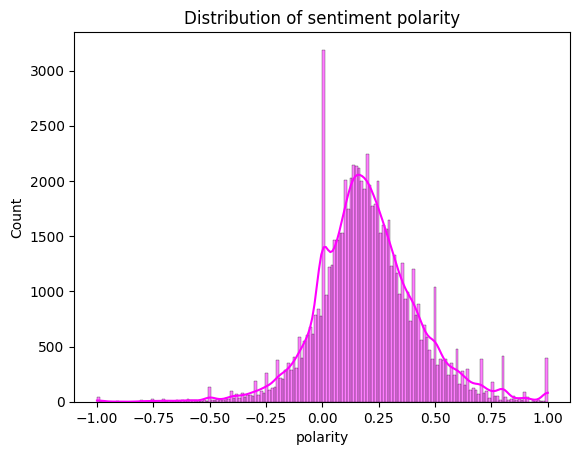

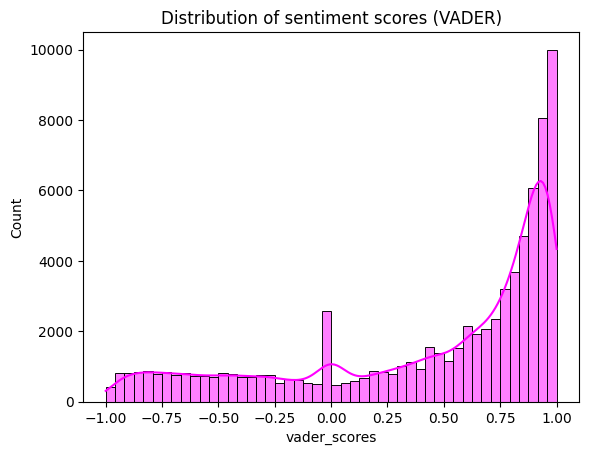

In [22]:
# Analyzing sentiment using TextBlob and VADER
df_named['polarity'] = df_named['review/text'].apply(lambda x: TextBlob(x).sentiment.polarity)
analyzer = SentimentIntensityAnalyzer()
df_named['vader_scores'] = df_named['review/text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Performing topic modeling using LDA
texts = [doc.split() for doc in df_named['text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary)
topics = lda_model.print_topics()

# Displaying the topics
for topic in topics:
    print(topic)
    
# Visualizing the results
sns.histplot(data=df_named, x='polarity', kde=True, color='magenta')
plt.title("Distribution of sentiment polarity")
plt.show()

sns.histplot(data=df_named, x='vader_scores', kde=True, color='magenta')
plt.title("Distribution of sentiment scores (VADER)")
plt.show()

To get to know the text charasteristics better LDA (Latent Dirichlet Allocation) was used. The model assumes that documents are made up of multiple topics, and each topic is made up of a set of words. The algorithm takes a corpus of documents as input and tries to identify the underlying topics based on the frequency of words within each document. LDA assumes that each document contains a mixture of topics and each word in the document is associated with one of the topics. \
The algorithm shows 5 indentified topics with top 10 words in each of them. The topics are usually based on the reviewed product or some common features of given product. \
The first plot shows sentiment polarity - in this dataset the reviews are rather positive. This is proven by the fact that the plot resembles normal distribution with mean at 0.25 value. Sentiment polarity ranges from -1 (negative sentiment) to 1 (positive sentiment) where 0 is neutral. The peak on 0.0 can be also observed so there is a significant amount of neutral reviews too. \
The second plot show the VADER (Valence Aware Dictionary and sEntiment Reasoner) analysis. It is based on vader score which also ranges from -1 to 1 based on negativity or positivity of analyzed text. This method uses a dictionary with scores for many words and expressions and, what's more an algorithm that takes the context into consideration. It also shows that positive reviews are the majority of the dataset and that neutral reviews are standing out.

#### Sentiment analysis

In [23]:
# Labeling
df_named['sentiment'] = df_named['review/score'].apply(lambda score: 1 if score > 3 else 0)

# Showing the basic information
positive_reviews = df_named['sentiment'].sum() / len(df_named) * 100
negative_reviews = 100 - positive_reviews
print(f"Percentage of positive reviews: {positive_reviews:.2f}%. Negative reviews: {negative_reviews:.2f}%")

# Preparing training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_named['text'], df_named['sentiment'], test_size=0.2, random_state=42)

# Converting the text data into a numerical representation using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Training and evaluating a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24224\1668413268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_named['sentiment'] = df_named['review/score'].apply(lambda score: 1 if score > 3 else 0)


Percentage of positive reviews: 60.75%. Negative reviews: 39.25%
Accuracy: 0.79, Precision: 0.80, Recall: 0.87, F1 score: 0.84


C:\Users\Lenovo\Desktop\cv\CellphonesDataAnalysis\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


After sentiment analysis it is really easy to see whether the product has a positive or negative review. The perecentages of positive and negatice reviews are a confirmation for the conclusions from sentiment histograms. This information is stored in the Sentiment column. Based on this column a machine learning model was trained. The model could have been based on various binary classification algorithms such as Decision Trees or SVM, but Logistic Regression was chosen. The evaluation showed that the model works well.

In [24]:
# sample 33% of the rows randomly
sample_df = df_named.sample(frac=0.33, random_state=42)
sample_df = sample_df.reset_index(drop=True)
sample_df

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text,text,polarity,vader_scores,sentiment
0,B0001YX9ZI,Etymotic Research ETY-COM ER22-C Noise-Isolati...,31.842842,ACM5UZCJ8IQXK,Mark A. Criden,0.666667,5.0,2006-11-10,Awesome headset!,"I've tried so many headsets, and have never be...",awesom headset,0.315000,0.5422,1
1,B000EBHW4W,MOTOROLA OEM BR50 BATTERY FOR RAZR V3 V3c V3m ...,4.900000,AT6I6VVZSI89G,John J. Wright,0.000000,2.0,2010-03-04,A little bet better than the old one.,Shipping was prompt. The battery is a little b...,littl bet better old one,0.094318,0.2049,0
2,B000AOKTKW,ANYCOM HS-890 Bluetooth Headset,31.842842,A3PAO3AR1I3JXO,"Z. Zhou ""E&E maven""",0.000000,1.0,2007-06-02,absolutely the worst,I bought one of this from [...] half year ago ...,absolut worst,-0.080556,-0.8975,0
3,B000L7GLLY,iPaq hw6500 / hw6515 Retractable Synch & Charg...,20.240000,A21L2AP1FOP1PF,Krishna Revuru,0.000000,5.0,2007-03-15,Excellent Shopping experience.,Purchasing with this vendor was definitely an ...,excel shop experi,0.133333,0.4019,1
4,B0009MA86A,Tekkeon Mp3300 Mypower All Mobile Power,31.842842,A28NEOQUTNVRRZ,"R. Cormack ""rcormack""",0.700000,2.0,2006-12-25,Powers laptops?,Our family bought two of these items as Christ...,power laptop,0.022444,-0.6862,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25280,B000KX3FRC,"HP iPaq hw6925 Unlocked Cell Phone with Wi-Fi,...",31.842842,A2E4ZPOW1X7RUA,"Eric Lazarian ""New England Calvinist""",1.000000,4.0,2009-01-09,A fine PDA phone for most users,"As PDA phones go, this is/was one of the bette...",fine pda phone user,0.224861,0.9834,1
25281,B0009W8DL2,Jabra BT350 Bluetooth Headset,39.990000,A1N5FSCYN4796F,"Philip R. Heath ""Gadgets, Music, & Books""",1.000000,5.0,2006-08-18,Best Bluetooth Headset I've Ever Used!!,Your first question is what other headsets am ...,best bluetooth headset ever use,0.151232,0.9911,1
25282,B000FPGZTA,"Motorola V710, A840, E815 Ultra Capacity Exten...",28.990000,A2FVSCTK9W09NA,S. Kagno,0.000000,5.0,2008-05-08,Powerful Battery,The Battery and cover is great...the phone I p...,power batteri,0.266335,0.0000,1
25283,B0009W8DKI,Jabra C250 EarWave Boom Headset for 2.5mm Plugs,2.990000,AOKSIW68GC5FD,Y. Garcia,0.000000,4.0,2007-09-15,Great hands free ear piece,The sound is great and it sometimes feels like...,great hand free ear piec,0.334524,0.9173,1


Because of computational reasons the decision about sampling was made. Some of the next algorithms are going to be executed on a 33% randomly selected rows from the original dataset. Those algorithms should be performed on original dataset if the technical conditions are met. There was an attempt to choose a strategy with dividing the set to batches and then concatenating the results of manipulations on every single batch. However, this also unfortunately did not work.

#### Clustering

In [25]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_anon['text'])

# Trying to find optimal hyperparameters for the DBSCAN algorithm
silhouette_scores = []
for eps in np.arange(0.1, 1.0, 0.1):
    for min_samples in range(2, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)
        labels = dbscan.labels_
        if np.max(labels) > 0: # ensure there is at least one cluster
            score = silhouette_score(X, labels)
            silhouette_scores.append((eps, min_samples, score))
best_eps, best_min_samples, best_score = max(silhouette_scores, key=lambda x: x[2])
print(f'Best hyperparameters: eps={best_eps}, min_samples={best_min_samples}, score={best_score}')

# Fitting the DBSCAN with the found hyperparameters and showing the clusters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(X)
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0) # count the number of clusters
print(f'Number of clusters: {n_clusters}')
for i in range(n_clusters):
    cluster_idx = labels == i
    cluster_text = df_anon.loc[cluster_idx, 'review/summary']
    print(f'Cluster {i}:')
    print(cluster_text.head(5))


Best hyperparameters: eps=0.6, min_samples=2, score=0.13072633978716214
Number of clusters: 196
Cluster 0:
3     Can you hear me now...Can you hear me now?
73                                      Hear me?
Name: review/summary, dtype: object
Cluster 1:
5                Works Great
40     Doesn't work with S56
94              Works for me
131              Works great
181             doesn't work
Name: review/summary, dtype: object
Cluster 2:
10                  Excellent Product
1074    Excellent Product and Service
Name: review/summary, dtype: object
Cluster 3:
11             Good product
844     A Very Good Product
1454           Good product
1615      very good product
Name: review/summary, dtype: object
Cluster 4:
12      Nokia data cables
2229       the data cable
Name: review/summary, dtype: object
Cluster 5:
14                               Headset
834                        Great headset
897                        Great headset
2177    Are you on your headset again???
Name: revie

The results of clustering were not very satisfying on the sample_df. There were attempts to use KMeans method and agglomerative clustering, however they ended up with worse results than presented DBSCAN (agglomerative clustering took a lot of time to execute and KMeans achieved the worst silhouette score). That is why the author decided to present clustering on the dataset with anonymous reviews. Similarly to previous attempts there are a lot of clusters created and not all of them are correctly grouped. Also the score is not satisfying. It could be a great start to further analysis but the author does not have the skills yet (but is willing to learn).

#### Recommender system

In [26]:
vectorizer = TfidfVectorizer()
product_titles = vectorizer.fit_transform(sample_df['product/title'])

# Calculating similarity of the products
cosine_sim_matrix = cosine_similarity(product_titles)

def get_similar_products(product_id, n=5):
    """
    Find the top n products that are most similar to the given product ID based on their titles.

    Parameters
    ----------
    product_id : str
        The product ID to search for.
    n : int, optional
        The number of similar products to return (default is 5).

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the top n products that are most similar to the given product ID.
        The DataFrame contains two columns: 'product/productId' and 'product/title'.
    """
    unique_products = sample_df.groupby('product/productId').first().reset_index()
    idx = unique_products.index[unique_products['product/productId'] == product_id].tolist()[0]
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i for i, _ in sim_scores[1:n+1]]
    
    return unique_products.loc[top_indices, ['product/productId', 'product/title']]

# Example usage on 'B000JIK92C' product
get_similar_products('B000JIK92C')

,product/productId,product/title
367,B000099BE3,Belkin SANYO 8100 LEATHER CASE ( F8V6256 )
395,B0000AHYJ7,Body Glove EarGlove Max Headset - 2.5mm
430,B0000C7BZ6,Jabra EarGels - Small
657,B0002LK89A,Nokia HS-4W Bluetooth Headset
827,B0003033S8,Nokia 6235i/6236i ACP-12U OEM Travel Charger


This is a recommender system that returns top n products that are similar to the given one basen on their titles. This could be very useful to recommend the returned products to the users that bought the one passed to the function. It could increase the sales significantly.

#### Time Series analysis

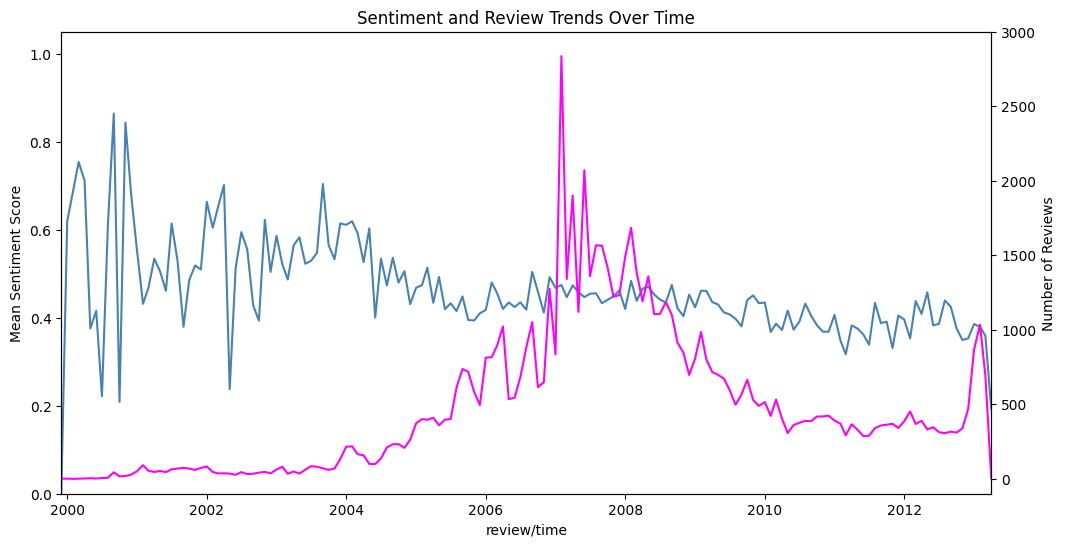

In [27]:
df_named.set_index('review/time', inplace=True)
# Resampling the data by month and calculating mean sentiment score and number of reviews
df_monthly = df_named.resample('M').agg({'vader_scores': 'mean', 'review/userId': 'count'})

# Plotting mean sentiment score and number of reviews over time
fig, axs = plt.subplots(figsize=[12,6])
axs1 = axs.twinx()
sns.lineplot(x=df_monthly.index, y=df_monthly['vader_scores'], ax=axs, color='steelblue')
sns.lineplot(x=df_monthly.index, y=df_monthly['review/userId'], ax=axs1, color='magenta')
axs.set(title="Sentiment and Review Trends Over Time", xlim=[df_monthly.index[0], df_monthly.index[-1]], ylim = [0, 1.05], ylabel='Mean Sentiment Score')
axs1.set(ylim=[-100,3000], ylabel='Number of Reviews')
plt.show()

Approaching the data from the other side, a time series is used to show how the amount of reviews and their mean sentiment changed overtime. The most interesting facts are that the peak of reviews amount took place in 2007 and that mean sentiment score has a downward trend. \
At the very beginning the mean sentiment was very unstable but always above 0 which means that the reviews were rather positive the whole time. Later the values happened to be more stabilized and it is clearly visible than the mean drops each year. \
Coming back to the number of reviews, after the peak in 2007 the values also dropped but at the end of the dataset (circa 2013) they peaked again. 2013 was the year when Amazon introduced AmazonFresh (it offers the delivery of groceries including fresh fruits and vegetables). This is not connected to the topic of the dataset but because of this release Amazon was all over the news and it might have reminded people to log in and leave a review or two. However, this is only an uncertain suggestion and can be treated as an interesting fact.

#### DImensionality reduction

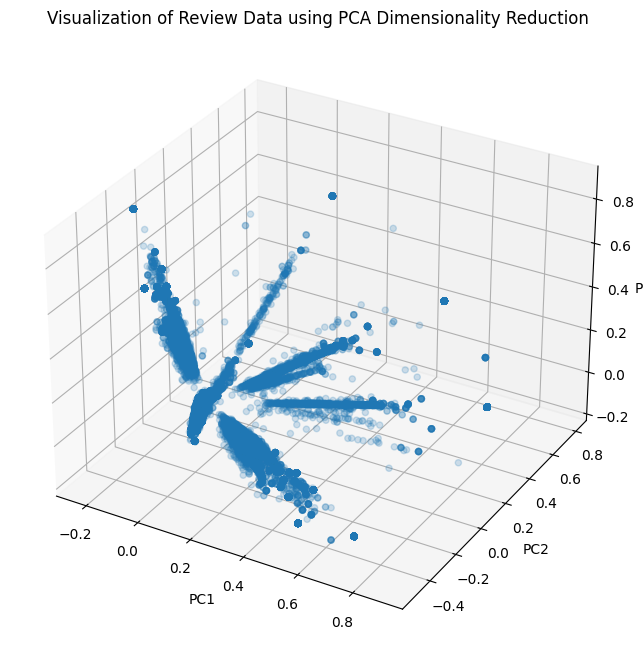

In [28]:
# Making a list of the reviews and vectorizing it using TF-IDF
reviews = df_named['text'].tolist()
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(reviews)

# Reducing the dimensionality using PCA and visualizing results
pca = PCA(n_components=3)
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_matrix[:,0], pca_matrix[:,1], pca_matrix[:,2], alpha=0.2)
ax.set(xlabel='PC1', ylabel='PC2', zlabel='PC3', \
       title="Visualization of Review Data using PCA Dimensionality Reduction")
plt.show()


The PCA algorithm reduces the TF-IDF matrix to 3 dimensions - each representing another variable. \
In this PCA plot the relationships between the variables are showed, each point represents a review, and the position of the point in the plot indicates how similar or dissimilar it is to other reviews. The distance between two points indicates how different their underlying features are. \
It is visible that there are a lot of groups of points clustered together which means that there are sets of similar reviews. Clustering can be done on this data but, as mentioned before, it is not so easy.

#### Visualzations more or less related to previous section

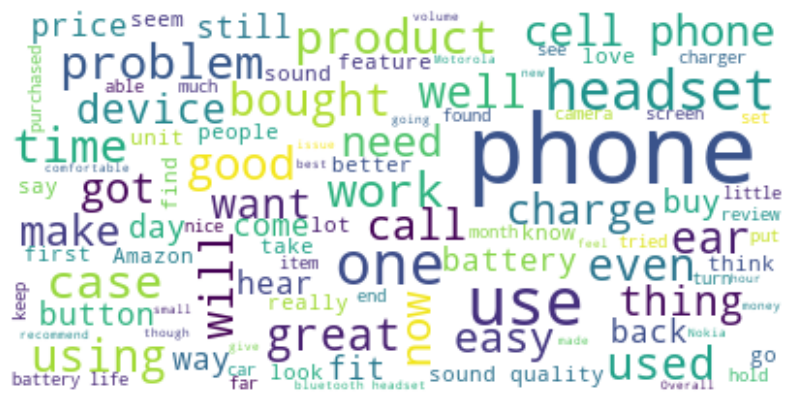

In [29]:
# Creating wordcloud image based on the reviews
text = " ".join(review for review in df_named['review/text'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The wordmap shows the most popular words in review and helps to understand the most common topics. The result is not very surprising - the words revolve around cellphones, their accesories and the quality of the products. However, it is useful to see such visualization.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24224\1162529247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_named['review/length'] = df_named['review/text'].apply(len) # Length of review might be an interesting variable


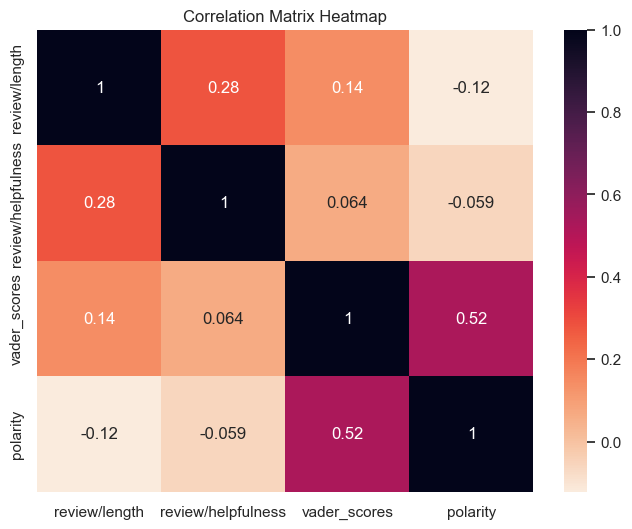

In [30]:
# Checking correlation between the variables
df_named['review/length'] = df_named['review/text'].apply(len) # Length of review might be an interesting variable
df_heatmap = df_named[['review/length', 'review/helpfulness', 'vader_scores', 'polarity']].copy()
corr_matrix = df_heatmap.corr()
sns.set(style="white")
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="rocket_r")
plt.title('Correlation Matrix Heatmap')
plt.show()

The heatmap unfortunately does not provide many interesting patterns. The visible correlation is the one between vader scores and polarity - it is known that they are directly related. Unfortunately, there are not any significant correlations beween other variables. Only review helpfulness is moderately correlated to the length of the review - the longer the review is, the more helpful.

## Summary

The dataset provided a lot of information about the cellphones and their accesories reviews submitted on Amazon website. The analyzed reviews were collected between circa 2000 and 2013. At the beginning customers were tending to leave the reviews anonymously but later (2006/2007) that changed. The analysis focused on the reviews that were not anonymous. Overall, the majority of the reviews were positive. Several machine learning alogirthms were used to perform the analysis. In addition to the machine learning algorithms, several exploratory data analysis techniques were applied to gain insights into the data, including sentiment analysis, topic modeling, and dimensionality reduction. The results of the analysis showed that the most commonly mentioned topics in the reviews were related to product features such as battery life, screen size, and sound quality. The dataset can be used to inform product development and marketing strategies for cellphone and accessory manufacturers.